In [1]:
from imageio import imread
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import time

%matplotlib inline

In [2]:
import tools._init_paths
import dataset
import torch
import torchvision.transforms as transforms
from dataset import custom_transforms

from utils.data_manipulation import add_dist_along_vector, add_dict_perpendicular_vector, rotate_point_by_angle
from utils.data_manipulation import get_object_aligned_box, plot_image_coordinates

from core.evaluate import normalize_theta

In [3]:
from config import cfg
cfg.merge_from_file('experiments/3_hrnet_coords.yaml')

In [4]:
cfg.DATASET.NAME = 'seadragon'#'mantaray' #'hammerhead'
cfg.LOCAL = True

# Custom transforms unit testing

In [26]:
train_dataset = eval('dataset.'+cfg.DATASET.CLASS)(cfg, True, None)
#valid_dataset = eval('dataset.'+cfg.DATASET.CLASS)(cfg, False, None)

loading annotations into memory...
Done (t=0.18s)
creating index...
index created!


In [27]:
from dataset.custom_transforms import RandomHorizontalFlip, RandomVerticalFlip, RandomRotate, RandomScale, Resize
from dataset.custom_transforms import CropObjectAlignedArea, ResizeKeepRatio

In [28]:
tf_test = { 'Horizontal flip': RandomHorizontalFlip(p=1.), 
            'Vertical flip': RandomVerticalFlip(p=1.),
            'RandomRotations': RandomRotate(degrees=90),
            'RandomScale': RandomScale(scale=(0.8, 1.2)),
            'Resize': Resize(256),
            'ResizeKeepRatio': ResizeKeepRatio(256),
            'CropObjectArea': CropObjectAlignedArea(0., 1.),
}

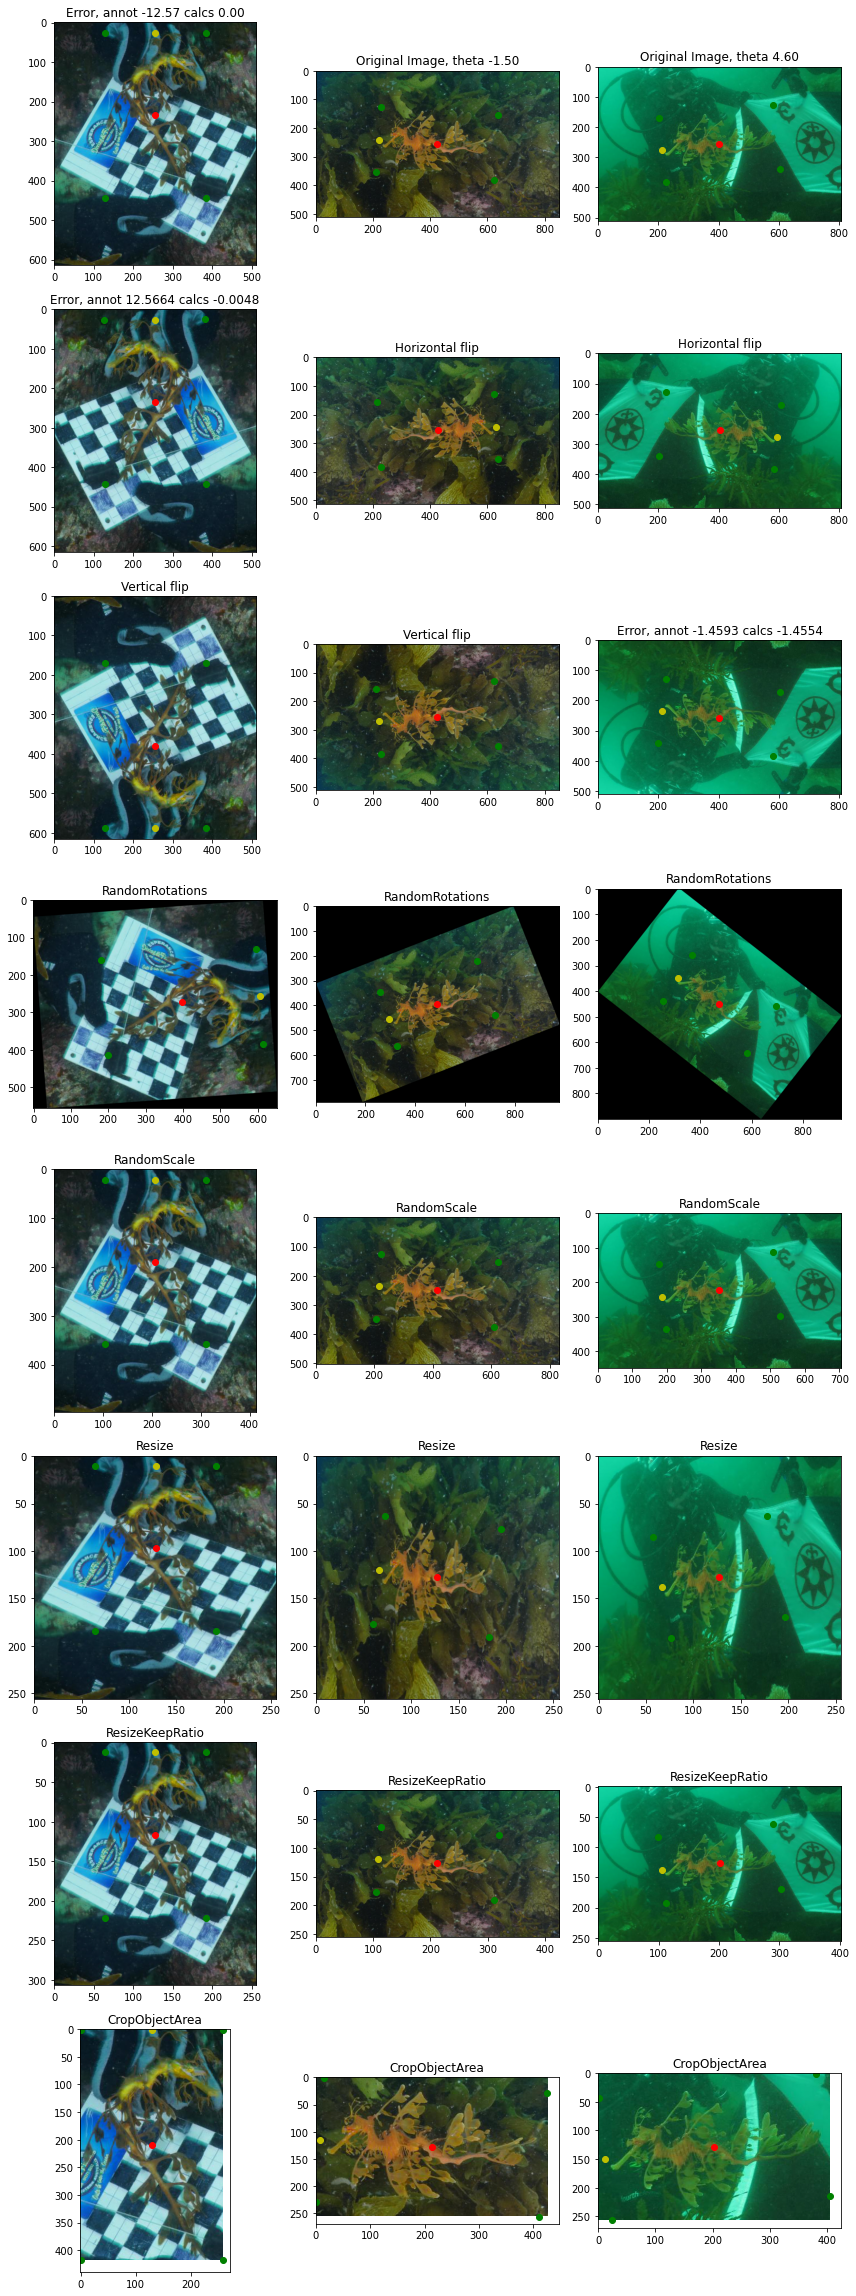

In [32]:
fig, ax = plt.subplots(nrows=len(tf_test)+1, ncols=3, figsize=(3*4, (len(tf_test)+1)*4))
for c in range(3):
    image, xc, yc, xt, yt, w, theta = train_dataset[random.randint(0, len(train_dataset)-1)]
    plot_image_coordinates(ax[0, c], image, xc, yc, xt, yt, w)
    theta_coord = np.arctan2(yt-yc, xt-xc) + math.radians(90)
    
    if abs(theta_coord - theta) < 1e-3:
        ax[0,c].set_title('Original Image, theta {:.2f}'.format(theta))
    else:
        ax[0,c].set_title('Error, annot {:.2f} calcs {:.2f}'.format(theta, theta_coord))
        
    r = 1
    for name, tf in tf_test.items():
        #Apply transformation
        image_, xc_, yc_, xt_, yt_, w_, theta_ = tf((image, xc, yc, xt, yt, w, theta))
        plot_image_coordinates(ax[r, c], image_, xc_, yc_, xt_, yt_, w_)
        #Verify that theta after transform is correct
        theta_aug = np.arctan2(yt_-yc_, xt_-xc_) + math.radians(90)
        #print('annot {:.2f} cals {:.2f} {}'.format(theta_, theta_aug, abs(theta_aug - theta_)))
        if abs(normalize_theta(theta_aug, False) - normalize_theta(theta_, False)) < 1e-3:
            ax[r,c].set_title(name)
        else:
            ax[r,c].set_title('Error, annot {:.4f} calcs {:.4f}'.format(theta_, theta_aug))
        r += 1

plt.tight_layout()

In [11]:
plt.bar(d.keys(), d.values(), width=10, align='edge')

NameError: name 'd' is not defined

# Test annotations (computed theta vs gt_theta)

In [31]:
n_test = 100
for i in range(n_test):
    image, xc, yc, xt, yt, w, theta = train_dataset[i]
    theta_coord = np.arctan2(yt-yc, xt-xc) + math.radians(90)
    theta = normalize_theta(theta, False)
    theta_coord = normalize_theta(theta_coord, False)
    
    #Check annotations
    if abs(theta_coord - theta) > 1e-2:
        print('ID {} Initial Annot Error, annot {:.2f} calcs {:.2f}'.format(i, theta, theta_coord))
        
    tf = random.choice(list(tf_test.values()))
    #Apply transformation
    image_, xc_, yc_, xt_, yt_, w_, theta_ = tf((image, xc, yc, xt, yt, w, theta))
    #Verify that theta after transform is correct
    theta_aug = np.arctan2(yt_-yc_, xt_-xc_) + math.radians(90)
    theta_aug = normalize_theta(theta_aug, False)
    theta_ = normalize_theta(theta_, False)

    if abs(theta_aug - theta_) > 1e-2:
        print('ID {} Error, annot {:.4f} calcs {:.4f}'.format(i, theta_, theta_aug))

# Data Loader test

In [ ]:
train_transform = transforms.Compose([
                        #custom_transforms.CropObjectAlignedArea(scale=2.),
                        #custom_transforms.ResizeKeepRatio(min_size=600),
                        custom_transforms.RandomHorizontalFlip(p=0.5),
                        custom_transforms.RandomVerticalFlip(p=0.5),        
                        custom_transforms.RandomRotate(degrees=90, mode = 'edge'),
                        custom_transforms.RandomScale(scale=(0.8,1.2)),
                        custom_transforms.CropObjectAlignedArea(noise=0.05),
                        custom_transforms.Resize(cfg.MODEL.IMAGE_SIZE),
                        custom_transforms.ToTensor(),
                        custom_transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                               std =[0.229, 0.224, 0.225],
                                               input_size=cfg.MODEL.IMAGE_SIZE[0])
                        ])

In [ ]:
valid_transform = transforms.Compose([
                        #custom_transforms.CropObjectAlignedArea(noise=0.),
                        #custom_transforms.Resize(cfg.MODEL.IMAGE_SIZE),
                        #custom_transforms.ResizeKeepRatio(min_size=256),
                        custom_transforms.ToTensor(),
                        custom_transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                               std =[0.229, 0.224, 0.225],
                                               input_size=cfg.MODEL.IMAGE_SIZE[0])
                        ])

In [ ]:
train_dataset = eval('dataset.'+cfg.DATASET.CLASS)(cfg, True, train_transform)
valid_dataset = eval('dataset.'+cfg.DATASET.CLASS)(cfg, False, valid_transform)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                            batch_size=cfg.TRAIN.BS*len(cfg.GPUS),
                                            shuffle=True,
                                            num_workers=cfg.WORKERS,
                                            pin_memory=cfg.PIN_MEMORY
                                        )

In [ ]:
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                            batch_size=cfg.TEST.BS*len(cfg.GPUS),
                                            shuffle=False,
                                            num_workers=cfg.WORKERS,
                                            pin_memory=cfg.PIN_MEMORY
                                        )

In [ ]:
from utils.utils import unnormalize

In [ ]:
%%time
for elem in train_loader:
    start = time.time()
    images, xc, yc, xt, yt, w, theta = elem
    print('proc time {:.3f}s'.format(time.time()-start))
    break

In [ ]:
save_batch_images(images, torch.stack([xc, yc, xt, yt, w], dim=1)*256, theta, 'test', max_cols=2)

In [ ]:
images_un = unnormalize(images)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(4*4, 1*4))
for c in range(4):
    plot_image_coordinates(ax[c], 
                           images_un[c].numpy().transpose((1,2,0)), 
                           xc[c].numpy()*cfg.MODEL.IMAGE_SIZE[0], 
                           yc[c].numpy()*cfg.MODEL.IMAGE_SIZE[0], 
                           xt[c].numpy()*cfg.MODEL.IMAGE_SIZE[0], 
                           yt[c].numpy()*cfg.MODEL.IMAGE_SIZE[0], 
                           w[c].numpy()*cfg.MODEL.IMAGE_SIZE[0], 
                           theta[c].numpy())
    ax[c].set_title('Theta {:.0f}'.format(math.degrees(theta[c])))

In [ ]:
xc, yc, xt, yt, w, theta

# Models

In [5]:
import models

In [6]:
cfg.MODEL

CfgNode({'CORE_NAME': 'hrnet', 'PRETRAINED': 'models/hrnetv2_w32_imagenet_pretrained.pth', 'IMSIZE': [224, 224], 'PREDICT_THETA': False, 'EXTRA': CfgNode({'STAGE1': CfgNode({'NUM_MODULES': 1, 'NUM_RANCHES': 1, 'BLOCK': 'BOTTLENECK', 'NUM_BLOCKS': [4], 'NUM_CHANNELS': [64], 'FUSE_METHOD': 'SUM'}), 'STAGE2': CfgNode({'NUM_MODULES': 1, 'NUM_BRANCHES': 2, 'BLOCK': 'BASIC', 'NUM_BLOCKS': [4, 4], 'NUM_CHANNELS': [32, 64], 'FUSE_METHOD': 'SUM'}), 'STAGE3': CfgNode({'NUM_MODULES': 4, 'NUM_BRANCHES': 3, 'BLOCK': 'BASIC', 'NUM_BLOCKS': [4, 4, 4], 'NUM_CHANNELS': [32, 64, 128], 'FUSE_METHOD': 'SUM'}), 'STAGE4': CfgNode({'NUM_MODULES': 3, 'NUM_BRANCHES': 4, 'BLOCK': 'BASIC', 'NUM_BLOCKS': [4, 4, 4, 4], 'NUM_CHANNELS': [32, 64, 128, 256], 'FUSE_METHOD': 'SUM'})})})

In [7]:
model = models.orientation_net.OrientationNet(cfg, True)

In [8]:
images = torch.randn(4, 3, 224, 224)

In [9]:
output = model(images)

In [10]:
output.shape

torch.Size([4, 5])

# Theta angle to class

In [ ]:
te = [train_dataset[i][-1] for i in range(20)]
te

In [ ]:
for i, t in enumerate(te):
    print("{:.3f}\t {:.3f}\t {:.3f}\t {:.3f}".format(t, math.cos(t), ten[i], math.cos(ten[i])))

In [ ]:
np.arccos(np.cos(te))

In [ ]:
list(range(0, 8, 2))

# Evaluate predicted theta

In [8]:
import pickle

In [6]:
ds = 'spotteddolphin'
exp = '1_resnet_coords'

In [13]:
with open('output/{}_{}_v0/theta_gt.pkl'.format(ds, exp), 'rb') as file:
    theta_gt = pickle.load(file)

In [10]:
theta_gt.shape

(160,)

In [11]:
theta_gt

array([-1.4056476 ,  1.5707964 , -1.0401565 ,  1.4523064 , -1.0340309 ,
        1.5707964 , -1.0659349 , -0.88885266,  2.862145  , -0.39732435,
        1.0191413 ,  4.4920263 , -1.3045443 , -0.9342881 , -1.5629225 ,
       -1.0853453 ,  4.490307  ,  4.43873   , -1.351313  ,  1.3580645 ,
        4.2611246 , -1.541393  ,  2.1695051 , -1.0211544 , -0.96811974,
        4.39312   ,  4.681149  ,  2.4183154 ,  2.3289285 ,  2.5554385 ,
        3.9348648 , -1.1821711 ,  1.5473632 ,  1.1887515 ,  1.2075049 ,
       -1.2490457 , -1.5630445 ,  2.113643  ,  2.313667  ,  2.4850109 ,
        2.4227626 ,  2.1492023 ,  1.2025677 ,  1.6665031 , -0.72165483,
       -0.9557733 , -0.9372806 , -1.1797482 ,  4.64997   ,  1.9368528 ,
        1.7758722 ,  2.0275235 , -1.4843978 ,  1.9143353 , -1.4922183 ,
       -1.3410546 ,  1.2538534 ,  1.5707964 ,  1.3952042 ,  4.1243863 ,
        2.3727674 ,  1.4111496 ,  3.4937906 ,  4.2105656 ,  4.3085947 ,
        2.4883673 ,  2.0935855 ,  1.1071488 , -1.442473  ,  0.90

In [14]:
with open('output/{}_{}_v0/theta_preds.pkl'.format(ds, exp), 'rb') as file:
    theta_preds = pickle.load(file)

In [18]:
math.radians(10)

0.17453292519943295